# Machine Learning using Sentinel-2 Data

This example uses training data from the
[Coast Train](https://github.com/nick-murray/coastTrain) dataset
along with Sentinel-2 data to demonstrate how to use a
machine learning classifier, in this case, Random Forest, to
assign a class to each pixel.

This notebook combines lessons from previous notebooks into
a comprehensive worked example.

## Getting started

First we load the required Python libraries and tools.

In [6]:
# Reload functions during development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from ldn.typology import colors, classes as classes_values
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


## Training data

Load it.

In [ ]:
# Get the training data
training_data = gpd.read_file("training_data.geojson")
training_data = training_data[~training_data['outlier']] # Remove outliers from the training data
training_data.drop(columns=['outlier'], inplace=True) # Drop outlier column as it's no longer needed
class_attr = "lulc"

training_data.explore(
    column=class_attr,
    categorical=True,
    categories=(present_classes := sorted(training_data[class_attr].unique())),
    cmap=[colors[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)

In [9]:
# Remove geometry column for train/test split
training_data = training_data.drop(columns="geometry")

print(len(training_data))

# Split 70/30 into train/test. Splits the classes into train/test in a representative way.
train_gdf, test_gdf = train_test_split(training_data, test_size=0.3, stratify=training_data[class_attr], random_state=42)

print(f"Training set class distribution:\n{train_gdf[class_attr].value_counts()}")
print(f"Test set class distribution:\n{test_gdf[class_attr].value_counts()}")
print(train_gdf)

3177
Training set class distribution:
lulc
6    906
5    330
3    199
1    198
4    198
2    197
7    195
Name: count, dtype: int64
Test set class distribution:
lulc
6    389
5    142
2     85
3     85
4     85
1     85
7     83
Name: count, dtype: int64
      lulc     green      smad    swir16     bcmad       red      blue  \
2608     7  0.097577  0.000900  0.228532  0.026742  0.095185  0.051432   
1483     5  0.111355  0.000222  0.145868  0.047264  0.110283  0.082947   
1786     5  0.120045  0.001008  0.262880  0.034410  0.133492  0.076512   
3218     3  0.113500  0.000871  0.207303  0.035371  0.115562  0.070270   
1513     5  0.092930  0.000330  0.177685  0.030270  0.096588  0.062240   
...    ...       ...       ...       ...       ...       ...       ...   
147      6  0.054045  0.000924  0.019175  0.040376  0.019148  0.034603   
3015     4  0.051460  0.001737  0.033750  0.030217  0.038645  0.032183   
1042     6  0.042193  0.000651  0.012493  0.019452  0.009715  0.035373   
606  

## Create a classifier and fit a model

We pass in simple numpy arrays to the classifier, one has the
observations (the values of the red, green, blue and so on)
while the other has the classes.

In [10]:
# The classes are the first column
classes = np.array(train_gdf)[:, 0]
print(f"Classes: {classes}")

# The observation data is everything after the first column
observations = np.array(train_gdf)[:, 1:]

# Create a model...
classifier = RandomForestClassifier(class_weight='balanced')

# ...and fit it to the data
model = classifier.fit(observations, classes)

Classes: [7. 5. 5. ... 6. 6. 1.]


In [11]:
# Define features and target

feature_cols = [c for c in train_gdf.columns if c != class_attr]

low_importance = ["smad", "bcmad", "emad", "blue", "ln_bg", "bg"]
feature_cols_reduced = [f for f in feature_cols if f not in low_importance]

X_train = train_gdf[feature_cols_reduced].values
y_train = train_gdf[class_attr].values
X_test = test_gdf[feature_cols_reduced].values
y_test = test_gdf[class_attr].values

classifier = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=42)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Feature importance — drop noisy features
importances = pd.Series(model.feature_importances_, index=feature_cols_reduced).sort_values(ascending=False)
print("Feature importances:")
print(importances)
# Feature importance is probably the most useful next step — it'll tell you which bands are actually helping and which are adding noise.

target_names = [k for k, v in sorted(classes_values.items(), key=lambda x: x[1]) if v != 0]

print(classification_report(y_test, y_pred, target_names=target_names))

Feature importances:
elevation    0.086837
swir16       0.084767
ndwi         0.084045
nir08        0.083706
swir22       0.077216
mndwi        0.077179
mbi          0.073941
baei         0.065944
red          0.063959
green        0.063045
ndti         0.061737
bui          0.060236
ndvi         0.058734
bsi          0.058655
dtype: float64
              precision    recall  f1-score   support

  Tree Cover       0.62      0.59      0.61        85
   Grassland       0.51      0.44      0.47        85
    Cropland       0.44      0.44      0.44        85
     Wetland       0.87      0.85      0.86        85
    Built-up       0.57      0.78      0.66       142
       Water       0.99      0.98      0.99       389
       Other       0.41      0.27      0.32        83

    accuracy                           0.75       954
   macro avg       0.63      0.62      0.62       954
weighted avg       0.74      0.75      0.74       954



In [12]:
# geomad_dem=xr.open_dataset('geomad_dem.tif',engine="rasterio").astype(np.uint8).to_array().squeeze()
geomad_dem = xr.open_dataset("geomad_dem.nc")

stack = np.stack([geomad_dem[f].values.flatten() for f in feature_cols], axis=1)
stack = np.stack([geomad_dem[f].values.flatten() for f in feature_cols_reduced], axis=1)
stack = np.nan_to_num(stack, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

predictions = model.predict(stack)

# Reshape back to raster
prediction_map = predictions.reshape(geomad_dem[feature_cols_reduced[0]].shape)

# Wrap in DataArray
predicted_da = xr.DataArray(
    prediction_map,
    coords={"y": geomad_dem.y, "x": geomad_dem.x},
    dims=["y", "x"],
    name="lulc",
)

## Visualise our results


In [13]:
from matplotlib.colors import ListedColormap

from odc.geo.xr import assign_crs

predicted_da = assign_crs(predicted_da, crs="EPSG:6933")

class_indexes = list(colors.keys())
cmap = ListedColormap([colors[c] for c in class_indexes])

predicted_da.odc.explore(categories=class_indexes, cmap=cmap, legend=True)

              precision    recall  f1-score   support

  Tree Cover       0.62      0.59      0.61        85
   Grassland       0.51      0.44      0.47        85
    Cropland       0.44      0.44      0.44        85
     Wetland       0.87      0.85      0.86        85
    Built-up       0.57      0.78      0.66       142
       Water       0.99      0.98      0.99       389
       Other       0.41      0.27      0.32        83

    accuracy                           0.75       954
   macro avg       0.63      0.62      0.62       954
weighted avg       0.74      0.75      0.74       954



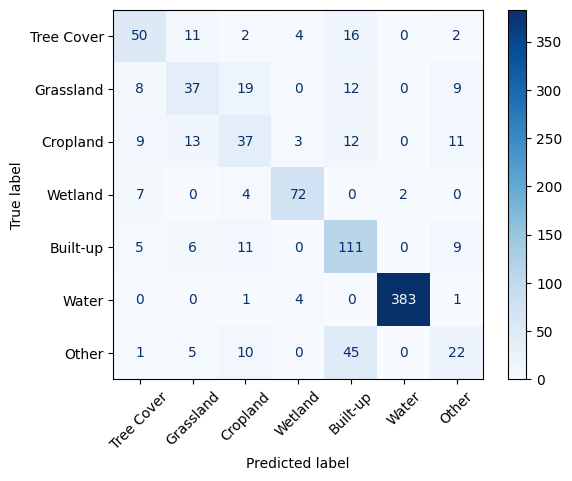

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = [k for k, v in sorted(classes_values.items(), key=lambda x: x[1]) if v != 0]

# Classification report
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45, cmap="Blues")